In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
moltean_fruits_path = kagglehub.dataset_download('moltean/fruits')

print('Data source import complete.')


Using Colab cache for faster access to the 'fruits' dataset.
Data source import complete.


## Introduction

> This notebook used the [Fruit 360](https://www.kaggle.com/moltean/fruits) dataset.

Instead of using CNN block to train the model, I tried to use the Vision Transformer (ViT) which is based on the paper [Image is worth 16 x 16 words](https://arxiv.org/abs/2010.11929). The model has already been build in the [**transformers**](https://huggingface.co/transformers/model_doc/vit.html) package.

Below are some resources to help readers to know more about ViT
* [Paper](https://www.kaggle.com/moltean/fruits)
* [Video](https://youtu.be/TrdevFK_am4)
* [Implement ViT from scratch using PyTorch](https://towardsdatascience.com/implementing-visualttransformer-in-pytorch-184f9f16f632)

### Download the trained model

I had put the trained weight on Google Drive. Users can download it by running below two blocks

In [ ]:
!pip install gdown

In [ ]:
# Download the model weight if users want to use the
#  trained model for this task (Fruits 360)
!gdown  https://drive.google.com/uc?id=1YfVZ7aUefO8Zx5UVnyJg8nIuOLyNcx-Y

Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1YfVZ7aUefO8Zx5UVnyJg8nIuOLyNcx-Y

but Gdown can't. Please check connections and permissions.


In [ ]:
# Pytorch
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision import transforms

# Build up the pretrained transformers model
from transformers import ViTFeatureExtractor, ViTModel

# Plot tool
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

In [ ]:
# Set up device and training hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 256
latent_dim = 256
epochs = 1
learning_rate = 5e-4

print(device)

cuda


## Build up dataset and dataloader

In [ ]:
# Add the transformation of image
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize((0.5,)*3, (0.5,)*3)
])

# Path for training and validation dataset
training_path = "../input/fruits/fruits-360/Training"
validating_path = "../input/fruits/fruits-360/Test"

In [ ]:
# Create train, val dataset
training_dataset = ImageFolder(moltean_fruits_path + "/fruits-360_100x100/fruits-360/Training", transform=data_transforms)
validating_dataset = ImageFolder(moltean_fruits_path + "/fruits-360_100x100/fruits-360/Test",transform=data_transforms)

# Create train, val dataloader
training_dataloader = DataLoader(training_dataset,batch_size=batch_size,shuffle=True)
val_dataloader = DataLoader(validating_dataset,batch_size=batch_size,shuffle=True)

## How our data look like?

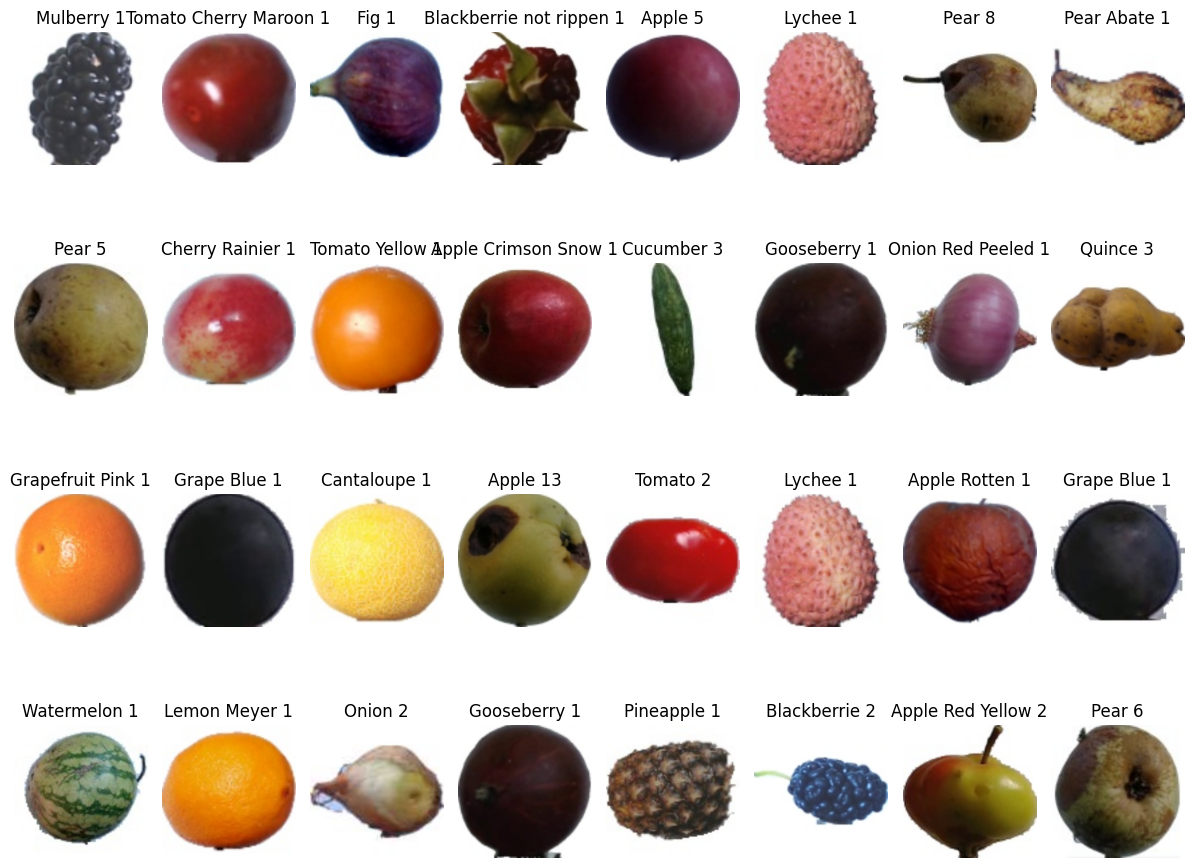

In [ ]:
image_size = 32

# Get the image from dataloader
show_images, show_labels = next(iter(training_dataloader))
show_images = show_images[:image_size]
show_labels = show_labels[:image_size]

ncols = 8
nrows = int(image_size / ncols) + 1

# Set up the figure size
plt.figure(figsize=(12, 12))


def inverse_normalized(image):
    # Clamp the value to (0.0, 1.0) for floats
    image = torch.clamp(input=image * 0.5 + 0.5,
                        min=0.0,
                        max=1.0)
    return image


for idx in range(len(show_images)):
    # Set up the subplot
    plt.subplot(nrows, ncols, idx + 1)

    # Close the axis and plot the image
    plt.axis("off")
    # Note that the label is change into integer, we should change it back to category
    plt.title(training_dataset.classes[show_labels[idx].item()])
    # Note that the image channel of tensor is: (channel, width, height)
    # We need to change it to (width, height, channel) which we use permute to realize it
    plt.imshow(inverse_normalized(show_images[idx].permute(1, 2, 0)))

# Avoid overlapping of different titles
plt.tight_layout()

## Build the model

In [ ]:
class CategoryClass(nn.Module):
    def __init__(self, vit, latent_dim, classes_):
        super(CategoryClass, self).__init__()

        self.classes_ = classes_

        # Set up model architecture
        self.vit = vit
        self.fc_1 = nn.Linear(768, latent_dim)
        self.fc_out = nn.Linear(latent_dim, self.classes_)
        self.dropout = nn.Dropout(0.2)

    def forward(self, in_data):
        # Type of output `BaseModelOutputWithPooling`
        vit_outputs = self.vit(in_data)

        # Shape of pooler_output: (batch_size, hidden_size)
        pooler_output = vit_outputs.pooler_output

        # Pass through the linear layout to predict the class
        # Shape of output: (batch_size, classes_)
        outputs = torch.relu(self.fc_1(pooler_output))
        outputs = self.fc_out(self.dropout(outputs))

        return outputs

In [ ]:
# Set up the pretrained model
vit = ViTModel.from_pretrained('google/vit-base-patch16-224')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Freeze the layers in vit exclude the pooler layers
for param in vit.parameters():
    param.requires_grad = False

vit.pooler.dense.weight.requires_grad = True
vit.pooler.dense.bias.requires_grad = True

In [ ]:
# Create the complete model
model = CategoryClass(vit,
                      latent_dim,
                      len(training_dataset.classes)).to(device)

In [ ]:
# Set up loss function and optimizers
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), learning_rate)

In [ ]:
# Save the training and validating information
training_loss_history =[]
training_accuracy_history = []
validating_loss_history = []
validating_accuracy_history = []

# We only train one epoch
#  Therefore, we save the batch information
batch_loss_history = []
batch_accuracy_history = []

for epoch in range(epochs):
    # Set to the train mode
    model.train()

    train_epoch_loss = 0.0
    train_epoch_accuracy = 0.0
    for idx, (images, labels) in enumerate(training_dataloader):
        # Move the data to the device
        images = images.to(device)
        labels = labels.to(device)

        # Pass through the model
        outputs = model(images)

        # Count the loss and update the parameters
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record the training information
        train_epoch_loss += loss.item()
        predict_class = outputs.argmax(dim=-1)
        accuracy = torch.sum(predict_class == labels).item() / labels.shape[0]
        train_epoch_accuracy += accuracy

        # Save the batch information
        batch_loss_history.append(loss.item())
        batch_accuracy_history.append(accuracy)

        # Print batch information
        print(f"Batch {idx + 1} in epoch {epoch + 1}/{epochs}")
        print(f"Average loss: {loss.item()}")
        print(f"Average accuracy {accuracy}")

    # Set to the eval mode
    model.eval()

    val_epoch_loss = 0.0
    val_epoch_accuracy = 0.0

    with torch.no_grad():
        for val_images, val_labels in val_dataloader:
            # Move data to the device
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            # Pass through model
            val_outputs = model(val_images)

            # Count the loss and accuracy
            val_epoch_loss += criterion(val_outputs, val_labels)
            val_predict_class = val_outputs.argmax(dim=-1)
            val_epoch_accuracy += torch.sum(val_predict_class == val_labels).item() / val_labels.shape[0]

    # Save the epoch information
    training_loss_history.append(train_epoch_loss / len(training_dataloader))
    training_accuracy_history.append(train_epoch_accuracy / len(training_dataloader))
    validating_loss_history.append(val_epoch_loss / len(val_dataloader))
    validating_accuracy_history.append(val_epoch_accuracy / len(val_dataloader))

    # Print the information
    print(f"Epoch {epoch + 1}")
    print(f"Average training loss: {training_loss_history[-1]}, Average validation loss: {validating_loss_history[-1]}")
    print(f"Average training accuracy: {training_accuracy_history[-1]}, Average validation accuracy: {validating_accuracy_history[-1]}")

Batch 1 in epoch 1/1
Average loss: 5.392594337463379
Average accuracy 0.0078125
Batch 2 in epoch 1/1
Average loss: 5.321894645690918
Average accuracy 0.0625
Batch 3 in epoch 1/1
Average loss: 5.294569969177246
Average accuracy 0.1015625
Batch 4 in epoch 1/1
Average loss: 5.2027482986450195
Average accuracy 0.12109375
Batch 5 in epoch 1/1
Average loss: 5.126739978790283
Average accuracy 0.16796875
Batch 6 in epoch 1/1
Average loss: 5.113251209259033
Average accuracy 0.16796875
Batch 7 in epoch 1/1
Average loss: 5.024280071258545
Average accuracy 0.1953125
Batch 8 in epoch 1/1
Average loss: 4.944533824920654
Average accuracy 0.1953125
Batch 9 in epoch 1/1
Average loss: 4.811890602111816
Average accuracy 0.2734375
Batch 10 in epoch 1/1
Average loss: 4.813461780548096
Average accuracy 0.203125
Batch 11 in epoch 1/1
Average loss: 4.736878395080566
Average accuracy 0.24609375
Batch 12 in epoch 1/1
Average loss: 4.614289283752441
Average accuracy 0.2578125
Batch 13 in epoch 1/1
Average loss: 

In [ ]:
# Save the model weight
torch.save(model.state_dict(), "model.pt")

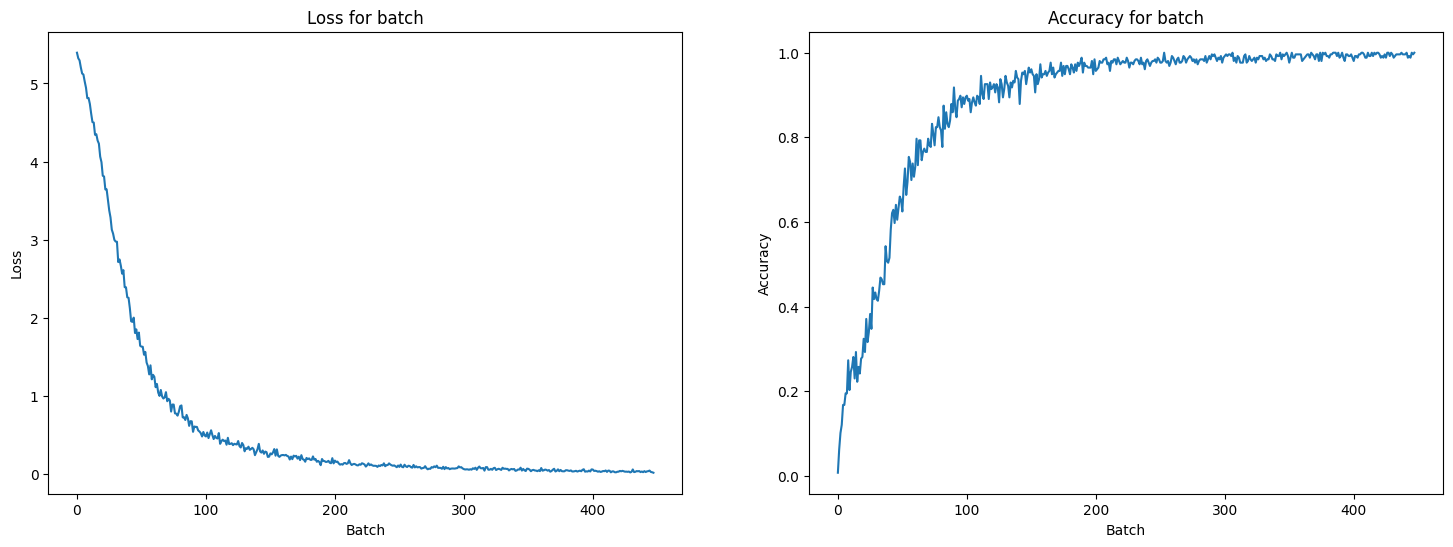

In [ ]:
# Plot the loss and accuracy
plt.figure(figsize=(18,6))

# Loss
plt.subplot(1, 2, 1)
plt.title("Loss for batch")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(batch_loss_history)

# Accuracy
plt.subplot(1, 2, 2)
plt.title("Accuracy for batch")
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.plot(batch_accuracy_history)

In [ ]:
prediction = []
true_labels = []

# Create the classification report on test dataset
with torch.no_grad():
    for val_images, val_labels in val_dataloader:
        # Move data to the device
        val_images = val_images.to(device)
        val_labels = val_labels.to(device)

        # Pass through model
        val_outputs = model(val_images)

        # Count the loss and accuracy
        val_predict_class = val_outputs.argmax(dim=-1)

        prediction.extend([predict_class.item() for predict_class in val_predict_class])
        true_labels.extend([val_label.item() for val_label in val_labels])

In [ ]:
import pandas as pd

# Output dict for making the report
report = classification_report(true_labels, prediction,
                               output_dict=True,
                               target_names=training_dataset.classes)
report_df = pd.DataFrame(report).transpose()

In [ ]:
# Show all columns
pd.set_option("display.max_rows", None)
report_df.head(134)

,precision,recall,f1-score,support
Apple 10,1.000000,1.000000,1.000000,231.0
Apple 11,1.000000,1.000000,1.000000,142.0
Apple 12,1.000000,1.000000,1.000000,154.0
Apple 13,1.000000,1.000000,1.000000,235.0
Apple 14,1.000000,1.000000,1.000000,154.0
Apple 17,1.000000,0.990050,0.995000,201.0
Apple 18,0.987654,1.000000,0.993789,160.0
Apple 19,1.000000,1.000000,1.000000,241.0
Apple 5,1.000000,1.000000,1.000000,146.0
Apple 6,1.000000,1.000000,1.000000,157.0


from matplotlib import pyplot as plt
_df_0['precision'].plot(kind='hist', bins=20, title='precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['f1-score'].plot(kind='hist', bins=20, title='f1-score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['support'].plot(kind='hist', bins=20, title='support')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='precision', y='recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='recall', y='f1-score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='f1-score', y='support', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7['precision'].plot(kind='line', figsize=(8, 4), title='precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_8['recall'].plot(kind='line', figsize=(8, 4), title='recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['f1-score'].plot(kind='line', figsize=(8, 4), title='f1-score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['support'].plot(kind='line', figsize=(8, 4), title='support')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
import os
print(os.listdir(moltean_fruits_path))

['fruits-360_100x100', 'fruits-360_3-body-problem', 'fruits-360_dataset_meta', 'fruits-360_original-size', 'fruits-360_multi']


In [ ]:
import os
print(os.listdir(moltean_fruits_path + "/fruits-360_100x100"))

['fruits-360']
